In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as fun

# Read Data and Process Data

In [2]:
ca_whole = pd.read_csv('ca_whole.csv')

In [3]:
# Drop Outlier
max_aqi = np.mean(ca_whole['AQI'])+2*np.std(ca_whole['AQI'])
min_aqi = np.mean(ca_whole['AQI'])-2*np.std(ca_whole['AQI'])
ca_whole = ca_whole.loc[ca_whole['AQI']<=max_aqi]

In [4]:
y = ca_whole.loc[:,['AQI']]
X= ca_whole.drop(columns = ['County Name', 'Date Local','Category','AQI'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32))
y_test = torch.tensor(y_test.values.astype(np.float32))
print(type(X_train))

<class 'torch.Tensor'>


# Create Model

In [6]:
class mlmodel(nn.Module):
    def __init__(self):
        super(mlmodel, self).__init__()
        self.fc1   = nn.Linear(18, 10)
        self.fc3  = nn.Linear(10, 1)
            
    def forward(self, y):
        y = fun.relu(self.fc1(y))
        y = self.fc3(y)
        return y
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

# Validation for Learning Rate

In [7]:
valid_rmse = [None] * 6
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(learning_rates)):
    rmse = 0
    learning_rate = learning_rates[i]
    for j in range(5):
        model = mlmodel()
        # Set up valid train sets
        X_valid_train, X_valid, y_valid_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
        for t in range(2000):
            # Forward pass
            model.eval()
            y_pred = model(X_valid_train)

            # Compute loss.
            loss = RMSELoss(y_pred, y_valid_train)
            # Zero gradients
            model.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
        # Calculate validation rmse
        y_pred = model(X_valid)
        rmse = (rmse + RMSELoss(y_pred, y_valid).item())/5
    # Store validation rmse
    valid_rmse[i] = rmse
valid_rmse

[8.600650299072266,
 8.596550864257813,
 15.665477796630858,
 5.474097329101562,
 4.955786024169922,
 7.275666409301758]

In [8]:
learning_rate = learning_rates[valid_rmse.index(np.min(valid_rmse))]
learning_rate

0.0001

# Train

In [9]:
model = mlmodel()
train_loss = [None]*4000
test_loss = [None]*4000
for t in range(4000):
    # Forward pass
    model.eval()
    y_pred = model(X_train)

    # Compute loss.
    loss = RMSELoss(y_pred, y_train)
    # Store Loss
    train_loss[t] = loss.item()
    test_loss[t] = RMSELoss(model(X_test), y_test).item()
    
    # Zero the gradients.
    model.zero_grad()
    
    # Backward pass
    loss.backward()

    # Update weights
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# Plots of the Result

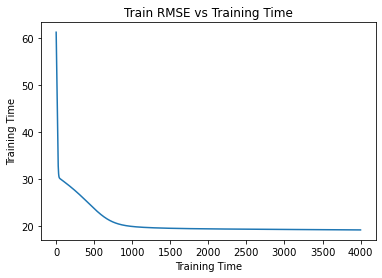

In [10]:
x = np.arange(4000)
plt.plot(x,train_loss)
plt.title("Train RMSE vs Training Time")
plt.xlabel("Training Time")
plt.ylabel("Training Time")
plt.show()

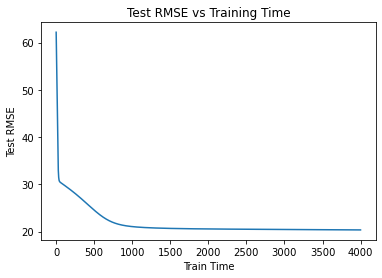

In [11]:
plt.plot(x,test_loss)
plt.title("Test RMSE vs Training Time")
plt.xlabel("Train Time")
plt.ylabel("Test RMSE")
plt.show()

In [12]:
print(train_loss[-1])
print(test_loss[-1])

19.096633911132812
20.335824966430664


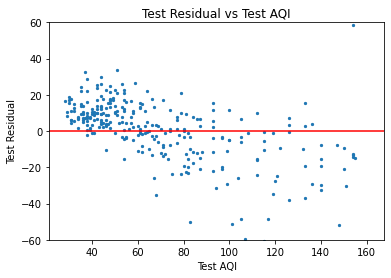

In [22]:
y_pred = model(X_test)
residual_train = y_pred - y_test
plt.scatter(y_test.detach().numpy(), residual_train.detach().numpy(), s=5)
plt.axhline(0, color ='Red')
plt.title("Test Residual vs Test AQI")
plt.xlabel("Test AQI")
plt.ylabel("Test Residual")
plt.ylim([-60,60])
plt.show()

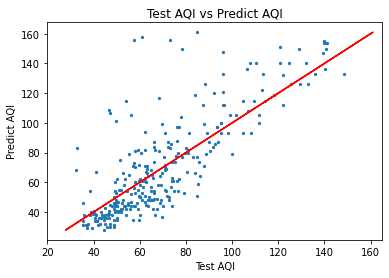

In [20]:
plt.scatter(y_pred.detach().numpy(), y_test.detach().numpy(),s=5)
plt.plot(y_test.detach().numpy(),y_test.detach().numpy(), color='red')
plt.title("Test AQI vs Predict AQI")
plt.xlabel("Test AQI")
plt.ylabel("Predict AQI")
plt.xlim([20, 165])
plt.show()